In [1]:
# Installing necessary packages:

In [2]:
# TensorFlow 2.15.0 and TensorFlow-Metal to enable GPU acceleration on macOS using Apple's Metal framework.
# Matplotlib for data visualization.

!pip install tensorflow==2.15.0 tensorflow-metal matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# Installing OpenCV with GUI support (not headless). 
    # The headless version excludes GUI dependencies like Qt and GTK which are useful for displaying images using functions like cv2.imshow, which will be needed for this project.

!pip install opencv-python 


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [76]:
# --- Standard Library Imports ---

import cv2 # OpenCV: Used for image processing, computer vision tasks, and handling images.
import os # OS module: Allows interaction with the file system — useful for creating directories and managing file paths.
import uuid # UUID: Used to generate unique identifiers, especially for naming image files without conflicts.
import random # Random: Helpful for testing, simulating variation, or introducing randomness in data selection.
import numpy as np # NumPy: Fundamental for numerical operations, especially with arrays and tensors.
                   # Tensors are multi-dimensional arrays used in deep learning for efficient data representation and GPU processing.
from matplotlib import pyplot as plt # Matplotlib: Enables image display, graph plotting, and data visualization for debugging and model analysis.

In [77]:
# --- TensorFlow and Keras Imports ---

# Import TensorFlow and its Keras API components.
# We'll be using the Functional API (instead of the simpler Sequential API) to build more flexible and customizable deep learning models.

import tensorflow as tf
from tensorflow.keras.models import Model # Base class for our custom model.
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten # Core layers for building convolutional neural networks (CNNs).

In [78]:
# --- Create Folder Structure for Dataset ---

# Define paths for the dataset directories:
    # We'll store images for training in three categories: 
        # - Anchor: Reference images
        # - Positive: Images of the same person as the anchor
        # - Negative: Images of different people (used for contrast)
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [79]:
# Creates the directories if they don't already exist.
# These will be used to store images collected or processed later.
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)
# exist_ok=True ensures python wont throw an error if the folder already exists

In [80]:
# --- Prepare LFW Dataset for Training ---

# We're using the "Labeled Faces in the Wild" (LFW) dataset as negative samples (i.e. different identities).
# These images will be moved into our 'data/negative' folder.
# The LFW dataset is extracted into a folder named 'lfw' in the same directory as this notebook.

for directory in os.listdir('lfw'):
    dir_path = os.path.join('lfw', directory)
    
    # Skip non-directory files (e.g., .DS_Store on macOS)
    if not os.path.isdir(dir_path): #checking for non-directory files
        continue #skipping to next item

    # Loop through image files inside each subfolder and move them to the 'negative' directory.
    for file in os.listdir(dir_path): 
        EX_PATH = os.path.join(dir_path, file) # Original image path
        NEW_PATH = os.path.join(NEG_PATH, file) # New path in negative samples
        os.replace(EX_PATH, NEW_PATH)

In [83]:
# Image Capture Pipeline for Siamese Network Training
# Utilizes OpenCV to capture live video frames and save labeled images (anchor and positive) for training the facial recognition model.

# --- Collect Anchor and Positive Images from Webcam ---
# Initialize webcam feed using OpenCV's VideoCapture class.
# Argument 0 selects the default webcam. The 'cap' object allows us to interact with the video stream.

cap = cv2.VideoCapture(0) # Initialize webcam capture using the default camera (index 0)

print("Press 'a' to capture an anchor image, 'p' for positive, and 'q' to quit.")

# Image Resizing Utility Function
# This function resizes any image input to a fixed 250x250 square while preserving aspect ratio.
# Ensures uniform image dimensions required for neural network training.
def resize_image(frame):
    if not ret or frame is None or frame.size == 0:
        print("Error: Failed to capture frame")
        return None
    
    h, w, _ = frame.shape  # Extract image dimensions (height and width)

     # Resize such that the smaller side becomes 250px while preserving aspect ratio
    if h > w:
        scale = 250 / w
        new_h = int(h * scale)
        resized = cv2.resize(frame, (250, new_h), interpolation=cv2.INTER_AREA)
        # cropping the center portion to get a 250x250 square
        start_y = (new_h - 250) // 2
        cropped = resized[start_y:start_y+250, 0:250] # Center crop
    else:
        # Height is smaller or equal, so make height = 250 and scale width proportionally
        scale = 250 / h
        new_w = int(w * scale)
        resized = cv2.resize(frame, (new_w, 250), interpolation=cv2.INTER_AREA)
        
        # cropping the center portion to get a 250x250 square
        start_x = (new_w - 250) // 2
        cropped = resized[0:250, start_x:start_x+250] # Center crop
    
    return cropped

# Ensure webcam opened successfully
if not cap.isOpened():
    print("Error: Could not open camera")
    exit()

# Capture loop — continuously reads frames from the webcam
while cap.isOpened(): # Read a frame; ret indicates success, frame is the image. The while loop runs as long as the camera is open.
    ret, frame = cap.read() #cap.read() captures a frame from the webcam | ret is a boolean data value that tells us if the frame was read successfully (True) or not (False)
                            #frame holds a NumPy array containing the image data: The captured image: where each pixel is stored as an array of intensity values (e.g., RGB).
    if not ret or frame is None or frame.size == 0:
        print("Error: Failed to capture frame")
        break
    
    final_frame = resize_image(frame)

    # Display the live webcam feed in a window titled 'Image Collection'
    cv2.imshow('Image Collection', final_frame)
    # This line is placed *after* frame processing and just before key input check,
    # ensuring the displayed frame is the latest valid resized version.

    # --- Image Capture Logic ---

    # Anchor Image Capture
    if cv2.waitKey(1) & 0xFF == ord('a'): #waits one millisecond then checks whats been pressed
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())) # Generate unique filename and filepath
        cv2.imwrite(imgname, final_frame) #write out anchor image

    # Collect positive image when 'p' is pressed
    if cv2.waitKey(1) & 0xFF == ord('p'): 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())) # Generate unique filename and filepath
        cv2.imwrite(imgname, final_frame) #write out positive image
        
    # Exit loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):#wait one millisecond then chek whats been pressed
        break


# Release webcam and close any OpenCV windows
cap.release()#releases the webcam
cv2.destroyAllWindows() #closes the image show frame
cv2.waitKey(1) # Ensures windows close properly - Allows OpenCV to process GUI closing events

Press 'a' to capture an anchor image, 'p' for positive, and 'q' to quit.


-1

In [87]:
# -----------------------------
# Data Augmentation for Model Robustness
# -----------------------------
# This function applies controlled random transformations to increase the diversity of the training dataset.
# It improves model generalization by simulating real-world variations in the input data.

def data_aug(img):
    data = []
    for i in range(3): # Generate 3 augmented versions per image
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2)) # Slight brightness variation
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        #img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        #img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        #img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        data.append(img)
    
    return data

In [88]:
import os
import uuid

In [89]:
#code for some testing
#this is how we would test a real life model - we are testing on a single image to see what the impact of this data augmentation would be
#img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
#img = cv2.imread(img_path)
#augmented_images = data_aug(img)

#for image in augmented_images:
#    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [90]:
# Augment all images in the positive image directory
for file_name in os.listdir(os.path.join(POS_PATH)):
     # Skip files that are not image files
    if not file_name.lower().endswith(('.jpg','.jpeg','.png')): # Skipping non-image files
        continue
    
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Warning: could not read image {img_path}")
        continue
    # Apply data augmentation to the loaded image   
    augmented_images = data_aug(img) 
    
    # Save each augmented image back to the positive directory with a unique name
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())


In [91]:
# Repeat the augmentation process for the anchor image directory
for file_name in os.listdir(os.path.join(ANC_PATH)):
    if not file_name.lower().endswith(('.jpg','.jpeg','.png')): # Skipping non-image files
        continue
    
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Warning: could not read image {img_path}")
        continue
        
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())


In [92]:
# Load file paths as TensorFlow datasets (used for training Siamese networks)
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(1000) # Load up to 1000 anchor image paths
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(1000) # Load up to 1000 positive image paths
negative  = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(1000) # Load up to 1000 negative image paths


In [93]:
#this code is just testing to show the concept and reason for using the numpy iterator
# Converts anchor dataset into a NumPy-compatible iterator
# This is useful for quick inspection or custom preprocessing outside TensorFlow

dir_test = anchor.as_numpy_iterator() #converts the anchor object to a standard python iterator
print(dirtest.next()# Print first file path (as numpy string)

b'data/anchor/1f2ee2ce-1167-11f0-967e-c227c87a1e56.jpg'


In [94]:
# Preprocessing function to decode, resize, and normalize images
# Handles decoding errors gracefully and ensures consistent input shape

def preprocess(file_path):
    try:
        #read the file
        byte_img = tf.io.read_file(file_path) #load our image from the file path. Will read our file as a bytes-like object
        
        try:
            #here we are using a tensorflow method decode to decode and load in the image
            img = tf.io.decode_jpeg(byte_img) #decode the jpeg

            img = tf.image.resize(img, (100,100)) #resize image to be 100x100 pixels as this is the size that our neural network needs the input to be.

            img = img / 255.0 # Normalize pixel values to range [0, 1]

            return img
   
        except:
            # Try fallback to decode_image which handles multiple formats
            try:
                img = tf.io.decode_image(byte_img, channels=3)
                img = tf.image.resize(img, (100, 100))
                img = img / 255.0
                return img
                
            except:
                print(f"Error: Could not decode image at {file_path}")
                return tf.zeros((100, 100, 3), dtype=tf.float32)

    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return tf.zeros((100, 100, 3), dtype=tf.float32)

# Example usage:
# img = preprocess('data/anchor/example.jpg')  # Returns a scaled and resized image tensor
# plt.imshow(img)                              # Visualize the image
# img.numpy().min(), img.numpy().max()         # Check pixel range (should be ~0.0 to ~1.0 after normalization)

In [95]:
# Demonstrates the use of the preprocess function:
# img = preprocess('data/anchor/example.jpg')
# plt.imshow(img)  # Displays the decoded, resized, and normalized image

In [96]:
# Create positive and negative labeled datasets
# Each element is a tuple: (anchor_path, comparison_path, label)
# Label is 1 for positive pair, 0 for negative pair

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# Merge both datasets into a unified training dataset
# This forms the complete training set used for contrastive or triplet loss
# Format: (anchor, comparison, label)

data = positives.concatenate(negatives)



In [97]:
# samples = data.as_numpy_iterator()
# example = samples.next()  
# Retrieves one (anchor, positive/negative, label) sample from the dataset.
# Think of the positive as the "twin" of the anchor in a matching pair.

In [98]:
#by this point we've created out labelled dataset, and now need to build, train and test partition which will be done below

In [99]:
# Define a function to preprocess both the anchor and comparison images (positive or negative) in each pair.
# This function is mapped across the dataset to prepare it for training.
# This returns a tuple of (processed anchor, processed comparison, label).

def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [103]:
# Building dataloader pipeline
# Apply preprocessing to every element in the dataset.
# Each dataset item is a tuple: (anchor_path, validation_path, label).

data = data.map(preprocess_twin)

# Shuffle the dataset to randomize the order of samples (helps prevent model bias).
# buffer_size=1024 holds that many elements in memory during shuffling for better randomness.
data = data.shuffle(buffer_size = 1024)

# NOTE: We're not caching the full dataset here to avoid excessive memory usage.
    # We'll selectively cache only the training data below for efficiency.

In [109]:
# -------- Training Data Preparation --------

# Split the dataset: take the first 70% for training.
train_data = data.take(round(len(data)*.7)) # Grabs the first 70% of the dataset (after shuffling) and rounds to the nearest whole number to ensure a valid number of samples.train_data = train_data.cache() # Cache only the train_data

# Cache only the training dataset to avoid recomputation in multiple epochs.
train_data = train_data.batch(16) # Batch data in groups of 16 images to improve training efficiency

# Prefetch 8 batches ahead to prepare the next set of samples while the current batch is being processed.
# This reduces input latency and maximizes GPU/CPU utilization.
train_data = train_data.prefetch(8) # Prefetches 8 batches ahead to reduce waiting time and improve GPU utilization by overlapping preprocessing and training


In [113]:
# -------- Testing Data Preparation --------

# Skip the first 70% of the data to avoid overlap with training data.
test_data = data.skip(round(len(data)*.7))

# Then take the remaining 30% as the testing set.
test_data = test_data.take(round(len(data)*.3)) 

# Apply the same batching and prefetching logic to testing data for consistency.
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [114]:
# Construct embedding model for facial verification using a CNN.
# This model extracts high-level features from images and converts them into embeddings (vector representations).

def make_embedding():
    
    # Define fixed input shape required by Keras Functional API
    inp = Input(shape = (100, 100, 3), name = "input_image") #defines a fixed input shape for the model
    
    # First Conv Block: captures basic patterns (edges, textures)
    c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1) 

    # Second Conv Block: increases filters to 128, detects more complex features
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)

    # Third Conv Block: reduces filter size to focus on finer facial details
    c3 = Conv2D(124, (4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)

    # Final Conv Block: deeper feature extraction
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3) #Final feature extraction, learning deep facial patterns.
    
    # Flatten and Dense layer to create the final 1D embedding
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1) # Sigmoid bounds output between 0 and 1 for consistent distance comparison
    
    return Model(inputs=[inp], outputs=[d1], name='embedding') 

In [115]:
embedding = make_embedding()

In [116]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 124)       25

In [117]:
# Custom L1 Distance layer to compare two embeddings (Manhattan Distance)
class L1Dist(Layer): 
    def __init__(self, **kwargs): 
        super().__init__()
    
    def call(self, input_embedding, validation_embedding): #this defines how the layer processes inputs
        return tf.math.abs(input_embedding - validation_embedding) # Computes element-wise absolute difference between the two embeddings, implementing L1 Distance (Manhattan Distance).

In [118]:
# Construct Siamese network model for face verification
def make_siamese_model():
    # Define inputs
    input_image = Input(name = 'input_img', shape = (100, 100, 3))
    validation_image = Input(name = 'validation_img', shape = (100, 100, 3))

    # Generate embeddings and compute distance
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

     # Classification layer with sigmoid to output probability of match
    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')
    

In [119]:
siamese_model = make_siamese_model()

In [120]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
batch_1[2]

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
      dtype=float32)

In [121]:
# Setup loss function and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy() # Measures how well the model separates matching vs non-matching pairs

In [122]:
# Adam optimizer for efficient gradient updates and stable convergence
opt = tf.keras.optimizers.legacy.Adam(1e-4)

In [123]:
# Establish checkpoints to save model progress during training.
# This ensures that if training is interrupted, we can resume from a specific point.

checkpoint_dir = '.\training_checkpoints' # Directory to store checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt') # Prefix for checkpoint files

# Track both optimizer and model
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model) # Checkpoint class to save optimizer and model

In [124]:
# Build train step function
# This function defines the operations for training a single batch of data:
# 1. Perform a forward pass
# 2. Compute the loss
# 3. Calculate gradients
# 4. Apply backpropagation to update model weights

@tf.function  # Compiles into a TensorFlow graph for faster execution
def train_step(batch):
    #record all of our operations
    with tf.GradientTape() as tape: #performs differentiations which allows us to capture our gradient from our neural network model

        # Extract input images (anchor and positive(validation) images)
        X = batch[:2]
        # Extract true labels
        y = batch[2]

        # Forward pass
        ypred = siamese_model(X, training = True) # Pass input to model; training=True enables training-specific behavior
                                            
        # Calculate loss
        loss = binary_cross_loss(y, ypred) # Compare predicted and true labels to get loss
        
    print(loss)
    
    # Compute gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Apply gradients to update model weights
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))#our optimiser is applying our learning rate 
    
    return loss 
#could add code to return loss values 

In [125]:
#Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [132]:
# Build the training loop
# Applies the train_step to each batch and loops over the entire dataset for multiple epochs

def train(data, EPOCHS):
    
    #loop through the epochs
    for epoch in range(1, EPOCHS+1):    
        print('/n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Initialize metrics
        r = Recall()
        p = Precision()
        
        # Loop through each batch in the dataset
        for idx, batch in enumerate(data):
            #run train step here
            loss = train_step(batch)
            
            # Predict using the current model
            yhat = siamese_model.predict(batch[:2])

            # Update evaluation metrics
            r.update_state(batch[2], yhat) #to update recall
            p.update_state(batch[2], yhat) #to update precision

            # Update progress bar
            progbar.update(idx + 1)

        # Print final metrics after each epoch           
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
            
        # Save model checkpoint every 10 epochs
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)


        

In [133]:
# Train the model
EPOCHS = 50
train(train_data, EPOCHS)

In [ ]:
#IMPORT METRICS SECTION

In [135]:
#EVALUATE THE MODEL
# To assess model performance, we will use two key metrics: precision and recall
    #Ideally, these aim to measure the accuracy of our model and how well it's performing classification 

# Assess model performance using precision and recall

from tensorflow.keras.metrics import Precision, Recall # Import precision and recall metrics from Keras library

In [136]:
#GET BATCHES OF DATA AND MAKE PREDICTIONS

In [137]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [138]:
# Make predictions on the test batch
y_pred = siamese_model.predict([test_input, test_val])
y_pred

1/1 [==============================] - 0s 11ms/step


array([[1.00000000e+00],
       [9.99999881e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [7.25023863e-09],
       [1.05321885e-08],
       [1.30219480e-08],
       [2.36603155e-05],
       [6.56586008e-06],
       [1.90474072e-08],
       [9.99996662e-01],
       [2.62336670e-07],
       [1.00000000e+00],
       [9.99994516e-01],
       [1.15351986e-06],
       [3.31718608e-09]], dtype=float32)

In [139]:
# Post-process predictions: convert probabilities to binary class labels
[1 if prediction > 0.5 else 0 for prediction in y_pred] #looping through all values in our y_pred example and converting them

# Alternatively:
# res = []
# for prediction in y_pred:
#     if prediction > 0.5:
#         res.append(1)
#     else:
#         res.append(0)



[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0]

In [140]:
y_true

array([1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

In [141]:
#CALCULATING METRICS

In [142]:
#CREATING A METRIC OBJECT
# Create metric object and calculate recall
m = Recall()
m.update_state(y_true, y_pred)
m.result().numpy()

1.0

In [143]:
# Evaluate on the full test dataset
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 8ms/step
1.0 1.0


In [144]:
# VISUALIZE RESULTS
# Compare a pair of input images from the test batch

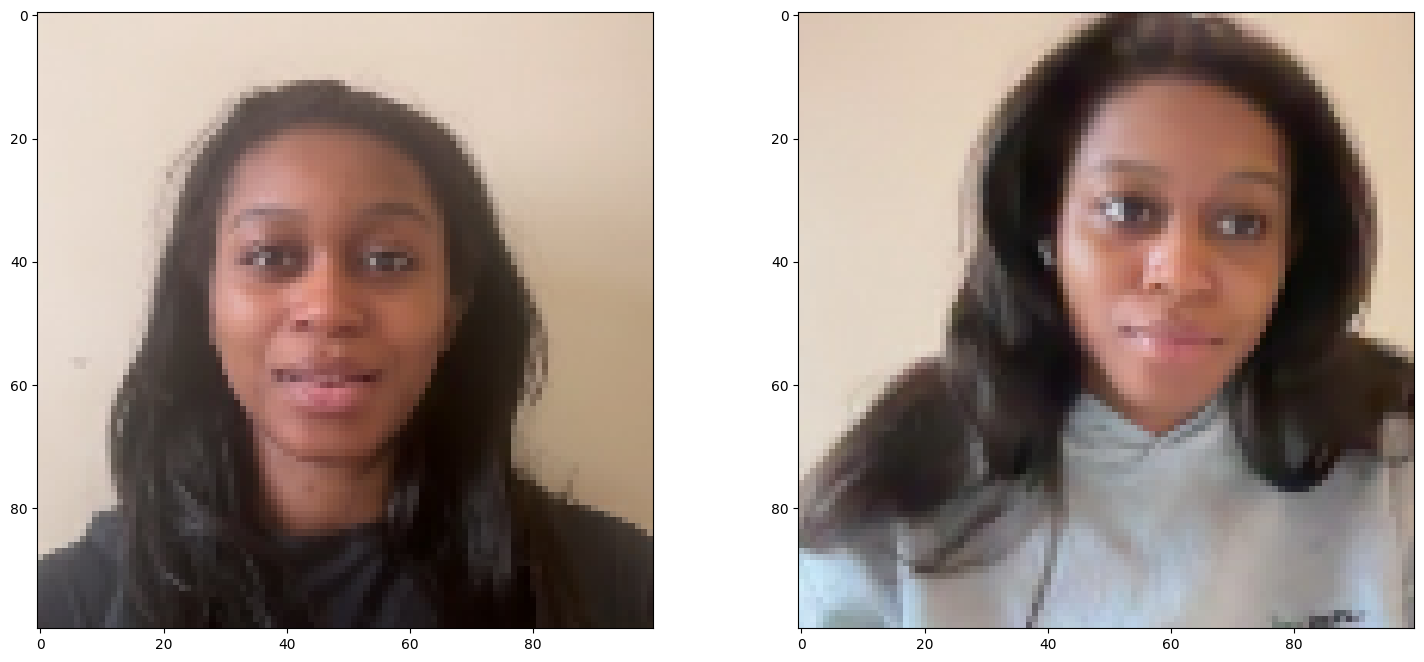

In [145]:

plt.figure(figsize = (18,8)) # Set the overall plot size (width, height) using matplotlib

# Display anchor image
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Display positive/negative test image
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Show the images
plt.show()

In [146]:
# Save the trained model

In [147]:
# Since we used a custom layer, we need to handle it during saving/loading
siamese_model.save('siamesemodelv2.keras')

In [148]:
# Reload the model, ensuring we include custom objects
model = tf.keras.models.load_model('siamesemodelv2.keras', custom_objects = {'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})
# We need to include the custom layer here because we'll need it when integrating with the Kivy app later

In [149]:
# Real-time test

In [150]:
# Make predictions with the reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 120ms/step


array([[3.9238596e-04],
       [1.0000000e+00],
       [2.1682110e-06],
       [1.0000000e+00],
       [1.7635243e-07],
       [1.5824692e-07],
       [9.9999845e-01],
       [1.0000000e+00]], dtype=float32)

In [151]:
# Display model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3893586   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [152]:
# Next steps

# Set up verification images: one for a match (positive) and one for no match (negative)
# Build a verification function (like Face ID)
# Use a loop to enable real-time facial verification

# Define a verification function to check input against stored samples
# Explanation of logic is in Notion doc

# Make sure the following folders are created in your working directory:
# 'application_data/verification_images' - for positive samples (copy from 'data' folder)
# 'application_data/input_image' - for incoming test images



In [157]:
os.listdir(os.path.join('application_data', 'verification_images'))

['77a5a060-1166-11f0-967e-c227c87a1e56.jpg',
 '760e8ce4-1166-11f0-967e-c227c87a1e56.jpg',
 '7c2d9912-1166-11f0-967e-c227c87a1e56.jpg',
 '7e5f9744-1166-11f0-967e-c227c87a1e56.jpg',
 '0ecf7394-1167-11f0-967e-c227c87a1e56.jpg',
 '80ac15a4-1166-11f0-967e-c227c87a1e56.jpg',
 '79bbdbf8-1166-11f0-967e-c227c87a1e56.jpg',
 '762d54f8-1166-11f0-967e-c227c87a1e56.jpg',
 '.DS_Store',
 '0f4e9d54-1167-11f0-967e-c227c87a1e56.jpg',
 '7ac97d20-1166-11f0-967e-c227c87a1e56.jpg',
 '7772b150-1166-11f0-967e-c227c87a1e56.jpg',
 '0d83ac4e-1167-11f0-967e-c227c87a1e56.jpg',
 '0f023b9e-1167-11f0-967e-c227c87a1e56.jpg',
 '8304447a-1166-11f0-967e-c227c87a1e56.jpg',
 '7b1619e6-1166-11f0-967e-c227c87a1e56.jpg',
 '7c60cbe8-1166-11f0-967e-c227c87a1e56.jpg',
 '7e92b610-1166-11f0-967e-c227c87a1e56.jpg',
 '788a68a8-1166-11f0-967e-c227c87a1e56.jpg',
 '80854f64-1166-11f0-967e-c227c87a1e56.jpg',
 '79098db8-1166-11f0-967e-c227c87a1e56.jpg',
 '83cfce7e-1166-11f0-967e-c227c87a1e56.jpg',
 '7ef87ae0-1166-11f0-967e-c227c87a1e56.jp

In [158]:
# Define the verification function
# Arguments: model, detection threshold, verification threshold

def verify(model, detection_threshold, verification_threshold):
   # Stores prediction results
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        # Load and preprocess input and validation images
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg')) 
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Run prediction on each validation image vs input image
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
    
    # Calculate verification metrics
    detection = np.sum(np.array(results) > detection_threshold) 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified 

In [159]:
# OpenCV real-time verification setup
cap = cv2.VideoCapture(0)

print("Press 'v' to verify an image, and 'q' to quit.")

# Resize captured image to 250x250, preserving aspect ratio

def resize_image(frame):
    if not ret or frame is None or frame.size == 0:
        print("Error: Failed to capture frame")
        return None
    
    h, w, _ = frame.shape  # Get frame dimensions
    
    if h > w:
        scale = 250 / w
        new_h = int(h * scale)
        resized = cv2.resize(frame, (250, new_h), interpolation=cv2.INTER_AREA)        
        start_y = (new_h - 250) // 2
        cropped = resized[start_y:start_y+250, 0:250]
    else:
        scale = 250 / h
        new_w = int(w * scale)
        resized = cv2.resize(frame, (new_w, 250), interpolation=cv2.INTER_AREA)
        start_x = (new_w - 250) // 2
        cropped = resized[0:250, start_x:start_x+250]
    
    return cropped

if not cap.isOpened(): #checking if camera was successfully opened
    print("Error: Could not open camera")
    exit()
    
while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret or frame is None or frame.size == 0:
        print("Error: Failed to capture frame")
        break

    final_frame = resize_image(frame)

    cv2.imshow('Verification', final_frame)
    
    # Implementing verification trigger - Press 'v' to verify
    if cv2.waitKey(1) & 0xFF == ord('v'):
        # Save input image to applicaton/input_image folder
        image_path = os.path.join('application_data', 'input_image', 'input_image.jpg')
        os.makedirs(os.path.dirname(image_path), exist_ok=True)
        
        # Ensure the image is saved correctly
        success = cv2.imwrite(image_path, final_frame)
        if not success:
            print(f"Error: Failed to save image to {image_path}")
        else:
            print(f'Input image saved to {image_path}')
        
        # Ensure verification_images folder exists
        verification_dir = os.path.join('application_data', 'verification_images')
        os.makedirs(verification_dir, exist_ok=True)
       
        cv2.imwrite(image_path, final_frame)
        print(f'Input image saved to {image_path}')
        
        # Run verification
        results, verified = verify(model, 0.2, 0.2) #inputs are, model, detection threshold, verification threshold.
        print('Verification result:', verified)
        
   # Press 'q' to quit   
   #previous: if cv2.waitKey(10) & 0xFF == ord('q'):
    elif cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        cv2.waitKey(1)
        cap.release()
        print("Exit loop successfully")
        break
        
# Exit the script gracefully
import sys
sys.exit(0)  
#exit() #added to ensure than the camera stops properly. exit() has been removed as the abrubt nature of it has caused kernel to restart


Press 'v' to verify an image, and 'q' to quit.
Input image saved to application_data/input_image/input_image.jpg
Input image saved to application_data/input_image/input_image.jpg
1/1 [==============================] - 0s 6ms/step
Error: Could not decode image at application_data/verification_images/.DS_Store
1/1 [==============================] - 0s 7ms/step
Verification result: True
Input image saved to application_data/input_image/input_image.jpg
Input image saved to application_data/input_image/input_image.jpg
1/1 [==============================] - 0s 7ms/step
Error: Could not decode image at application_data/verification_images/.DS_Store
1/1 [==============================] - 0s 7ms/step
Verification result: True
Input image saved to application_data/input_image/input_image.jpg
Input image saved to application_data/input_image/input_image.jpg
1/1 [==============================] - 0s 7ms/step
Error: Could not decode image at application_data/verification_images/.DS_Store
1/1 [=====

SystemExit: 0

/Users/anesah/Documents/Projects/Facial_Verification_Mobile_App/faceverapp/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
